# Reinforcement Learning Chess

### Monte Carlo tree search (MCTS)
The aim of this notebook is to build a chess AI that can plan moves and defeat a simple opponent in a regular game of chess. My approach can be summarized as follows:
- Instead of Q-learning (learning action values) I use "V-learning" (learning state-values).
    - An advantage is that the Neural Network can learn with fewer parameters since it doesn't need to learn a seperate value for each action. In my Q-learning and Policy Gradient notebook, the output vector has a size > 4000. Now the size is only 1.
- The V-network is updated using Temporal Difference (TD) Learning, like explained in Notebook 1. 
    - This option is the simplest to code.  Other options are TD-lambda and Monte Carlo Learning.
- The Architecture of the V-network is quite arbitrary and can probably be optimized. I used a combination of small and large convolutions, combined with convolutions that range a full file or rank (1-by-8 or 8-by-1).
- Moves are planned using Monte Carlo Tree Search. This involves simulating playouts. 
    - Monte Carlo Tree Search greatly improves performance on games like chess and go because it helps the agent to plan ahead.
- These playouts are truncated after N steps and bootstrapped. 
    - This reduces the variance of the simulation outcomes and gives performance gains, since the simulation doesn't require a full playout. 
- For this version, the opponent of the RL-agent is a myopic player, that always chooses the move that results in the most material on the board or a checkmate.

**Import**

In [1]:
# !pip install chess

     |████████████████████████████████| 141 kB 427 kB/s 
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext autoreload
%autoreload 2
# !pip install --upgrade git+https://github.com/arjangroen/RLC.git@maintain-tree  # RLC is the Reinforcement Learning package
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)import os
import inspect
import matplotlib.pyplot as plt

In [2]:
from keras.models import load_model

Using TensorFlow backend.
C:\Users\there\Anaconda3\envs\neuro140\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\there\Anaconda3\envs\neuro140\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\there\Anaconda3\envs\neuro140\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\there\Anaconda3\envs\neuro140

In [3]:
from RLC.real_chess import agent, environment, learn, tree
from endgame_environment import Board
import chess
from chess.pgn import Game

# these are FENS, which are a concise way of representing the board states
# 10 common end games were selected for training purposes
endgame_fens = [
    # King, queen, and three pawns vs king, queen, and three pawns
    "4k3/1p2pp2/8/8/8/8/1P2PP2/4K3 w - - 0 1",
    # King, rook, knight, bishop, and pawn vs king, rook, knight, bishop, and pawn
    "4k3/1prnbp2/8/8/8/8/1PRNBP2/4K3 w - - 0 1",
    # King, two bishops and three pawns vs king, two knights and three pawns
    "4k3/1p1bpp2/8/8/8/8/1P1NNP2/4K3 w - - 0 1",
    # King, two rooks and three pawns vs king, two rooks and three pawns
    "4k3/1p1rrp2/8/8/8/8/1P1RRP2/4K3 w - - 0 1",
    # King, queen, knight, bishop and pawn vs king, queen, knight, bishop and pawn
    "4k3/1pqnbP2/8/8/8/8/1PQNBp2/4K3 w - - 0 1",
    # King, queen, two bishops and pawn vs king, queen, two bishops and pawn
    "4k3/1pqbbP2/8/8/8/8/1PQBBp2/4K3 w - - 0 1",
    # King, queen, two knights and pawn vs king, queen, two knights and pawn
    "4k3/1pqnNP2/8/8/8/8/1PQnnp2/4K3 w - - 0 1",
    # King, queen, rook, bishop, and pawn vs king, queen, rook, bishop, and pawn
    "4k3/1pqrBP2/8/8/8/8/1PQRbp2/4K3 w - - 0 1",
    # King, queen, rook, knight, and pawn vs king, queen, rook, knight, and pawn
    "4k3/1pqrNP2/8/8/8/8/1PQRnp2/4K3 w - - 0 1",
    # King, rook, two knights and pawn vs king, rook, two knights and pawn
    "4k3/1prnNP2/8/8/8/8/1PRNnp2/4K3 w - - 0 1"
]

opponent = agent.GreedyAgent()
env = Board(opponent, FEN=None, endgame_fens=endgame_fens)
player = agent.Agent(lr=0.0005,network='big')
learner = learn.TD_search(env, player,gamma=0.9,search_time=0.9)
node = tree.Node(learner.env.board, gamma=learner.gamma)
player.model.summary()





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state (InputLayer)              (None, 8, 8, 8)      0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 4)      36          state[0][0]                      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 8)      264         state[0][0]                      
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 3, 3, 12)     876         state[0][0]                      
__________________________________________________________________________________________________
conv2d

### Launching the network

In [4]:
n_iters = 100000  # maximum number of iterations
timelimit = 3600 # maximum time for learning
network_replacement_interval = 10  # For the stability of the nearal network updates, the network is not continuously replaced



iter 0
game ended with result 0.0 and material balance -10.0 in 81 halfmoves
game ended with result -1.0 and material balance -12.0 in 70 halfmoves
game ended with result 0.0 and material balance -2.0 in 81 halfmoves
game ended with result -1.0 and material balance -18.0 in 16 halfmoves
game ended with result 0.01 and material balance 0.0 in 35 halfmoves
game ended with result -1.0 and material balance -16.0 in 18 halfmoves
game ended with result 0.0 and material balance 0.0 in 81 halfmoves
game ended with result 0.0 and material balance 0.0 in 81 halfmoves
game ended with result 0.03 and material balance 3.0 in 23 halfmoves
game ended with result 0.0 and material balance 9.0 in 51 halfmoves
iter 10
game ended with result 0.0 and material balance -4.0 in 81 halfmoves
game ended with result 0.01 and material balance 0.0 in 71 halfmoves
game ended with result 0.01 and material balance 0.0 in 75 halfmoves
game ended with result -1.0 and material balance -21.0 in 10 halfmoves
game ended 

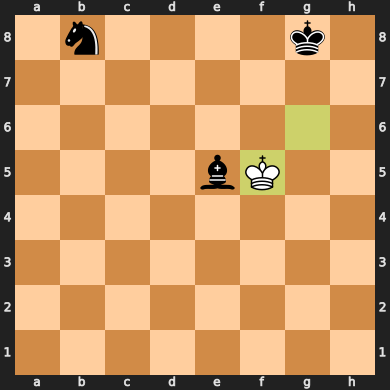

In [5]:
learner.learn(iters=n_iters,timelimit_seconds=timelimit,c=network_replacement_interval) 

### Learning performance 

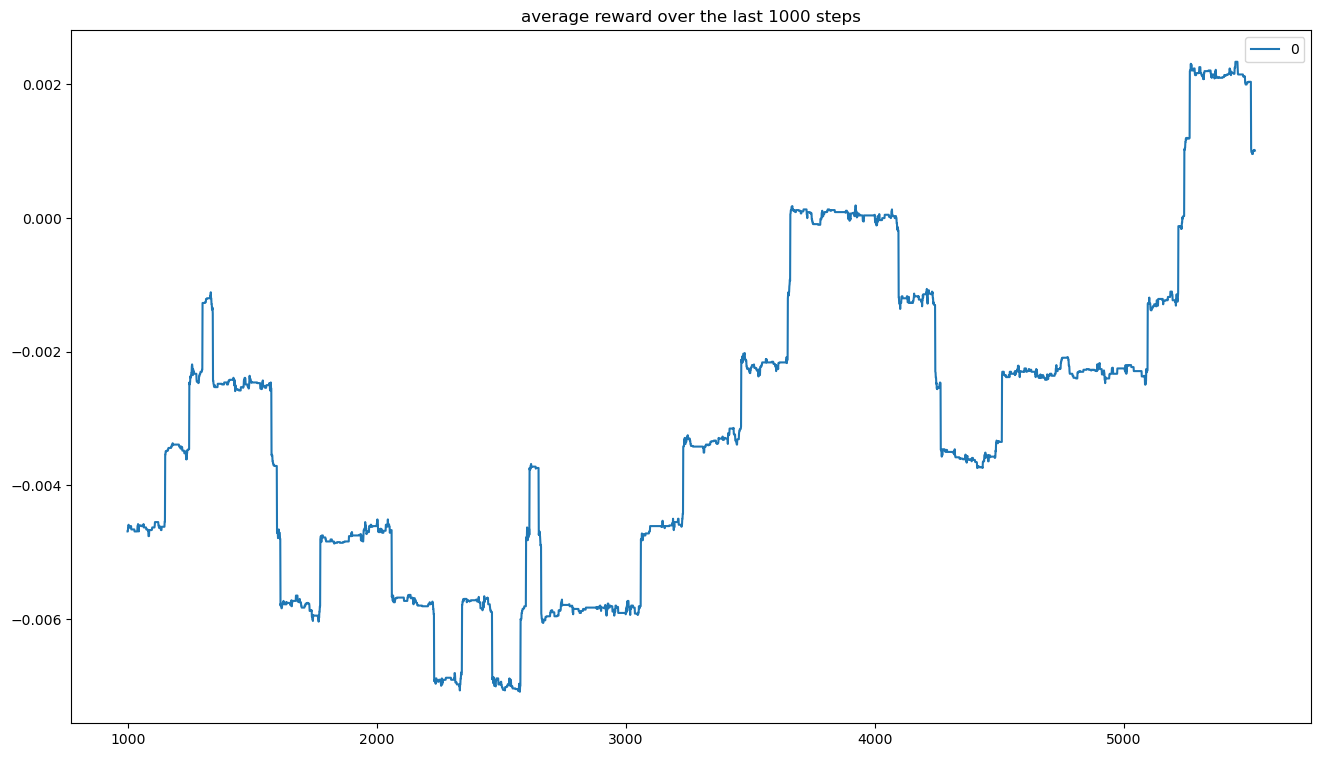

In [6]:
reward_smooth = pd.DataFrame(learner.reward_trace)
reward_smooth.rolling(window=1000,min_periods=1000).mean().plot(figsize=(16,9),title='average reward over the last 1000 steps')
plt.show()

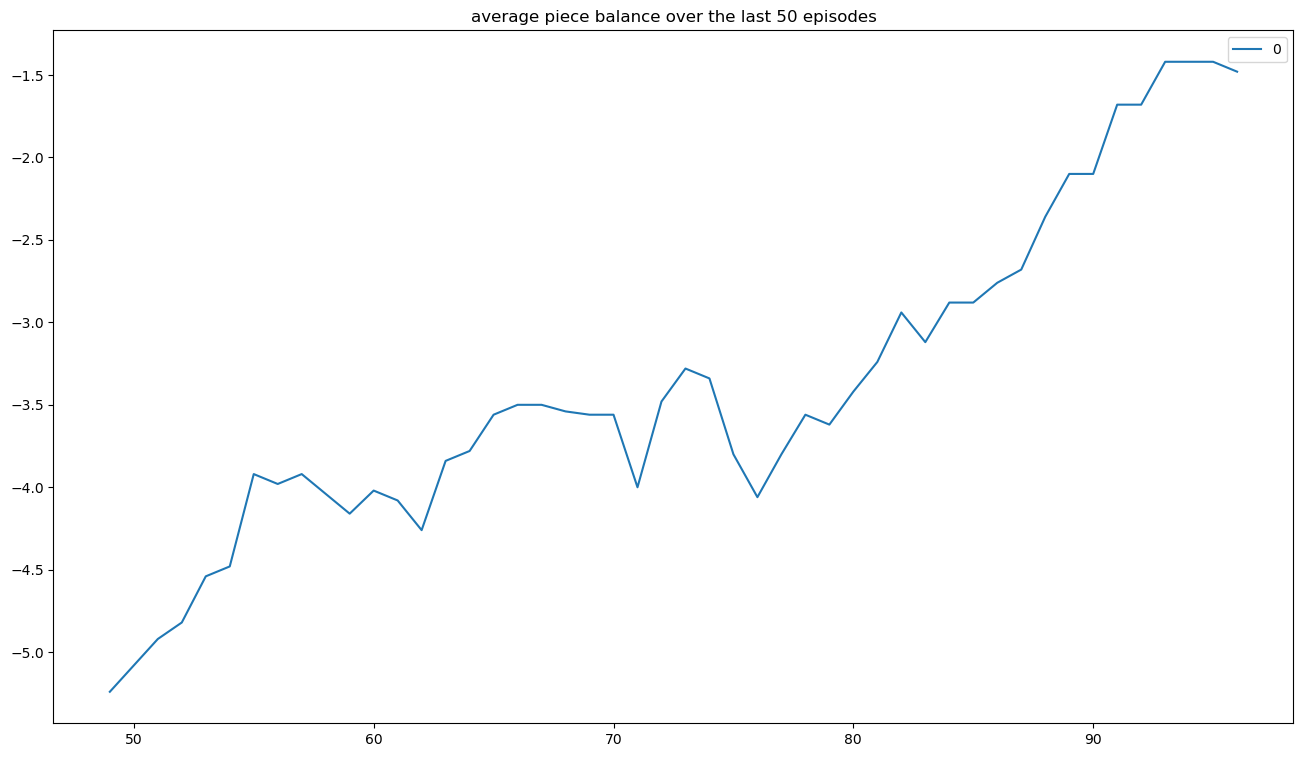

In [7]:
reward_smooth = pd.DataFrame(learner.piece_balance_trace)
reward_smooth.rolling(window=50,min_periods=50).mean().plot(figsize=(16,9),title='average piece balance over the last 50 episodes')
plt.show()

In [8]:
learner.agent.model.save('RLC_model_copy.h5')

### Final performance with large searchtime and more greedy behavior

In [9]:
learner.env.reset()
learner.search_time = 100
learner.temperature = 1/3

game ended with result 1.0 and material balance 9.0 in 57 halfmoves


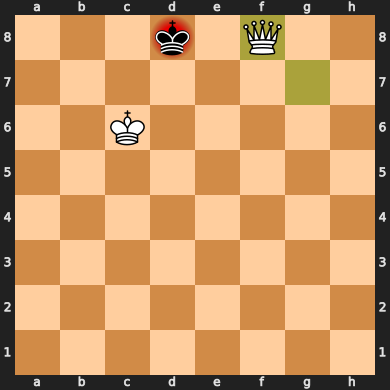

In [10]:
learner.play_game(1, maxiter=100)

In [11]:
pgn = Game.from_board(learner.env.board)
with open("rlc_pgn_copy_4","w") as log:
    log.write(str(pgn))

In [12]:
learner.agent.model.save('RLC_model_copy4.h5')

In [13]:
learner.env.reset()
learner.search_time = 100
learner.temperature = 1/3

In [14]:
learner.env.FEN

'4k3/1prnbp2/8/8/8/8/1PRNBP2/4K3 w - - 0 1'

game ended with result 0.01 and material balance 0.0 in 35 halfmoves


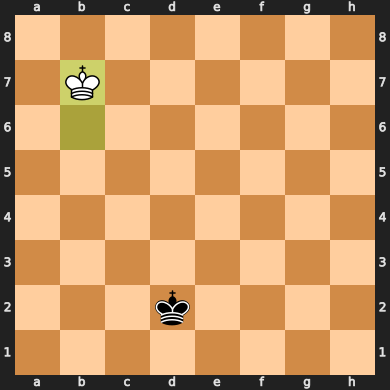

In [15]:
learner.play_game(1, maxiter=100)

In [16]:
pgn = Game.from_board(learner.env.board)
with open("rlc_pgn_copy_5","w") as log:
    log.write(str(pgn))

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [17]:
learner.agent.model.save('RLC_model_copy5.h5')

RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:03 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 00000224168B4088, total write size = 128, bytes this sub-write = 128, bytes actually written = 18446744073709551615, offset = 20168)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py\_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:03 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 00000224168B4088, total write size = 128, bytes this sub-write = 128, bytes actually written = 18446744073709551615, offset = 20168)


RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 0000022412106048, total write size = 16, bytes this sub-write = 16, bytes actually written = 18446744073709551615, offset = 20296)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py\_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 0000022412106048, total write size = 16, bytes this sub-write = 16, bytes actually written = 18446744073709551615, offset = 20296)


RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 00000224119742E8, total write size = 1024, bytes this sub-write = 1024, bytes actually written = 18446744073709551615, offset = 20312)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py\_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 00000224119742E8, total write size = 1024, bytes this sub-write = 1024, bytes actually written = 18446744073709551615, offset = 20312)


RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 00000224130A68B8, total write size = 32, bytes this sub-write = 32, bytes actually written = 18446744073709551615, offset = 21336)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py\_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 00000224130A68B8, total write size = 32, bytes this sub-write = 32, bytes actually written = 18446744073709551615, offset = 21336)


RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 000002247F787C38, total write size = 3456, bytes this sub-write = 3456, bytes actually written = 18446744073709551615, offset = 27664)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py\_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 000002247F787C38, total write size = 3456, bytes this sub-write = 3456, bytes actually written = 18446744073709551615, offset = 27664)


RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 000002241722A0A8, total write size = 48, bytes this sub-write = 48, bytes actually written = 18446744073709551615, offset = 21368)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py\_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 000002241722A0A8, total write size = 48, bytes this sub-write = 48, bytes actually written = 18446744073709551615, offset = 21368)


RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 0000022478501608, total write size = 8192, bytes this sub-write = 8192, bytes actually written = 18446744073709551615, offset = 34000)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py\_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 0000022478501608, total write size = 8192, bytes this sub-write = 8192, bytes actually written = 18446744073709551615, offset = 34000)


RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 0000022412921528, total write size = 64, bytes this sub-write = 64, bytes actually written = 18446744073709551615, offset = 21416)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py\_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 0000022412921528, total write size = 64, bytes this sub-write = 64, bytes actually written = 18446744073709551615, offset = 21416)


RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 00000224184FD028, total write size = 40960, bytes this sub-write = 40960, bytes actually written = 18446744073709551615, offset = 44896)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py\_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 00000224184FD028, total write size = 40960, bytes this sub-write = 40960, bytes actually written = 18446744073709551615, offset = 44896)


RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 00000224153B73C8, total write size = 80, bytes this sub-write = 80, bytes actually written = 18446744073709551615, offset = 21480)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py\_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 00000224153B73C8, total write size = 80, bytes this sub-write = 80, bytes actually written = 18446744073709551615, offset = 21480)


RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 000002241064E0F8, total write size = 768, bytes this sub-write = 768, bytes actually written = 18446744073709551615, offset = 88600)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py\_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 000002241064E0F8, total write size = 768, bytes this sub-write = 768, bytes actually written = 18446744073709551615, offset = 88600)


RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 000002241687DF08, total write size = 12, bytes this sub-write = 12, bytes actually written = 18446744073709551615, offset = 21560)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py\_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 000002241687DF08, total write size = 12, bytes this sub-write = 12, bytes actually written = 18446744073709551615, offset = 21560)


RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 000002241064E0F8, total write size = 768, bytes this sub-write = 768, bytes actually written = 18446744073709551615, offset = 89368)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py\_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 000002241064E0F8, total write size = 768, bytes this sub-write = 768, bytes actually written = 18446744073709551615, offset = 89368)


RuntimeError: Can't decrement id ref count (file write failed: time = Tue May  2 02:12:04 2023
, filename = 'RLC_model_copy5.h5', file descriptor = 5, errno = 28, error message = 'No space left on device', buf = 000002241687DF08, total write size = 12, bytes this sub-write = 12, bytes actually written = 18446744073709551615, offset = 21572)

Exception ignored in: 'h5py._objects.ObjectID.__dealloc__'
Traceback (most recent call last):
  File "h5py\_objects.pyx", line 201, in h5py._objects.ObjectID.__dealloc__
